# REINFORCE for the CartPole Environment
Gym's Cartpole Environment (https://gymnasium.farama.org/environments/classic_control/cart_pole/)

<center><img width="350"  align="right"  src=attachment:75d63883-c1a4-4839-946a-21020ec0b770.png /></center>

```
Description:

    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.

Action Space:

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.

    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |

Observation Space:

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | Cart Position         | -4.8                | 4.8               |
    | 1   | Cart Velocity         | -Inf                | Inf               |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
    | 3   | Pole Angular Velocity | -Inf                | Inf               |

Rewards:

    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
    including the termination step, is allotted. The threshold for rewards is 475 for v1.

Starting State:

    All observations are assigned a uniformly random value in `(-0.05, 0.05)`

Episode End:

    The episode ends if any one of the following occurs:

    1. Termination: Pole Angle is greater than ±12°
    2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Truncation: Episode length is greater than 500
```
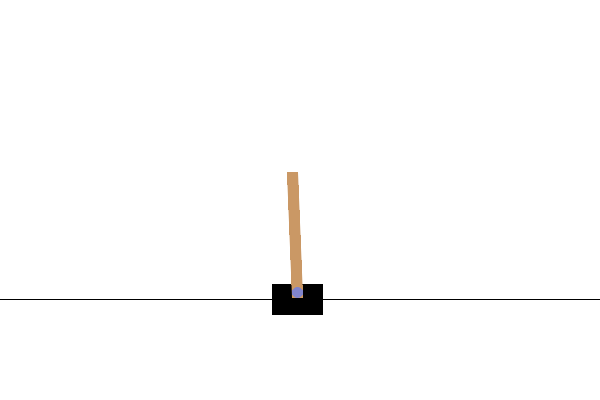

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import gymnasium as gym
from matplotlib import pyplot as plt
random.seed(0)

## Create Environment

In [2]:
# OpenAI Gym's Cartpole Environment
env = gym.make("CartPole-v1")

## Create Model

In [3]:
class SimpleNNPolicy(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.actfn = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.outfn = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.actfn(x)
        x = self.layer2(x)
        return self.outfn(x)

In [4]:
obs_size = env.observation_space.shape[0]  # shape of state vector
n_actions = env.action_space.n
hidden_size = 256

# set random seed
torch.manual_seed(0)
np.random.seed(0)

model = SimpleNNPolicy(obs_size, hidden_size, n_actions)
print(model)

SimpleNNPolicy(
  (layer1): Linear(in_features=4, out_features=256, bias=True)
  (actfn): ReLU()
  (layer2): Linear(in_features=256, out_features=2, bias=True)
  (outfn): Softmax(dim=0)
)


## The REINFORCE trainer
The input is our policy network $\pi_{\theta}$ which is used to collect a trajectory of state, action and reward triples $\tau = (S_0,A_0, R_1, \dots ,  S_{T-1}, A_{T-1} , R_{T})$. The expected return for a transition $t$ is $G_t = \sum_{k= t+1}^{T} \gamma^{k-t-1} R_t $.
The gradient with respect to the weights $\theta$ is calculated as $\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(A_t|S_t) G_t $. Here $\log$ is used as it is generally more well-scaled. The weights are updated by adding the gradient multiplied by the learning rate. 

In [5]:
class REINFORCETrainer:
    def __init__(self, model, env):
        self.model = model
        self.env = env
        self.learning_rate = 0.005 # learning rate
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.learning_rate)
        self.Horizon = 475  # max length of the trajectory triples
        self.MAX_TRAJECTORIES = 800  # number of episodes
        self.gamma = 0.99
        self.scores = []
        
    def train(self):
        for trajectory in range(self.MAX_TRAJECTORIES):
            curr_state = self.env.reset()[0]
            done = False
            transitions = []
            log_probs = []
            for t in range(self.Horizon):
                
                # probability distribution resulting from the network
                act_prob = self.model(torch.from_numpy(curr_state).float())
                
                # choose action according to the probabilities
                action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy())
                
                # record the transition (state, action, reward)
                transitions.append([curr_state, action, t + 1])
                
                # apply action to the environment
                curr_state, _, done, _, _ = self.env.step(action)
                if done:
                    break
            
            self.scores.append(len(transitions))
            max_reward = t
            rewards = [r for s, a, r in transitions]

            policy_losses = []
            returns = []

            ###################################################
            # YOU WILL IMPLEMENT THIS FUNCTION IN TASK 1 and Task 2
            returns = self.calculate_returns(transitions, rewards, self.gamma)
            ###################################################
            
            returns = torch.FloatTensor(returns)
            returns /= returns.max()

            states = torch.Tensor([s.tolist() for (s,  a, r) in transitions])
            pred_batch = self.model(states)

            actions = torch.Tensor([a for (s, a, r) in transitions])
            prob_batch = pred_batch.gather(dim=1, index=actions.long().view(-1, 1)).squeeze()

            ###################################################
            # YOU WILL IMPLEMENT THIS FUNCTION IN TASK 3
            policy_loss = self.compute_policy_loss(prob_batch, returns)
            ###################################################
            
            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()

            if trajectory % 50 == 0 and trajectory > 0:
                print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(self.scores[-50:-1])))

## Task 1

Your task is to implement the method `calculate_new_G` to compute the value of `new_G` for a given trajectory at a specific time step `t`. It takes as input the list of transitions, the list of rewards, the discount factor `gamma`, and the time step `t`. It iterates through the transitions starting from the current time step and calculates the discounted sum of rewards until the end of the trajectory. Finally, it returns the computed value of `new_G`.

In [6]:
def calculate_new_G(self, transitions, rewards, gamma, t):
    new_G = 0
    for k in range(t + 1, len(transitions) + 1):
        ### BEGIN SOLUTION
        power = k - t - 1
        new_G += (gamma ** power) * rewards[k - 1]
        ### END SOLUTION
    return new_G

# This adds the function as a method to the specified class.
setattr(REINFORCETrainer, "calculate_new_G", calculate_new_G)

## Task 2

Your task is to implement the method `calculate_returns`to calculate the `returns` for each time step of a trajectory. It takes as input the list of transitions, the list of rewards, and the discount factor `gamma`. It iterates through each transition, calling `calculate_new_G` to compute `new_G` for that time step. Then, it computes the return for that time step using `gamma` and `new_G`. Finally, it returns a list of returns corresponding to each time step of the trajectory.

In [7]:
def calculate_returns(self, transitions, rewards, gamma):
    returns = []
    for i, (s, a, r) in enumerate(transitions):
        new_G = self.calculate_new_G(transitions, rewards, gamma, i)
        ### BEGIN SOLUTION
        returns.append(gamma ** i * new_G)
        ### END SOLUTION
    return returns

# This adds the function as a method to the specified class.
setattr(REINFORCETrainer, "calculate_returns", calculate_returns)

## Task 3 

Your task is to implement the method `compute_policy_loss`, which takes two arguments: `prob_batch`, which is a batch of action probabilities predicted by the model, and `returns`, which represents the returns for each time step of the trajectory. It computes the policy loss.

In [8]:
def compute_policy_loss(self, prob_batch, returns):
    ### BEGIN SOLUTION
    policy_loss = -torch.sum(torch.log(prob_batch) * returns)
    ### END SOLUTION
    return policy_loss

# This adds the function as a method to the specified class.
setattr(REINFORCETrainer, "compute_policy_loss", compute_policy_loss)

## Initialize  the trainer

In [9]:
trainer = REINFORCETrainer(model, env)
trainer.train()

Trajectory 50	Average Score: 66.94
Trajectory 100	Average Score: 198.08
Trajectory 150	Average Score: 302.33
Trajectory 200	Average Score: 288.67
Trajectory 250	Average Score: 380.88
Trajectory 300	Average Score: 444.86
Trajectory 350	Average Score: 376.02
Trajectory 400	Average Score: 454.90
Trajectory 450	Average Score: 427.96
Trajectory 500	Average Score: 449.37
Trajectory 550	Average Score: 471.18
Trajectory 600	Average Score: 374.86
Trajectory 650	Average Score: 466.76
Trajectory 700	Average Score: 437.29
Trajectory 750	Average Score: 350.63


## Plotting the score per epoch

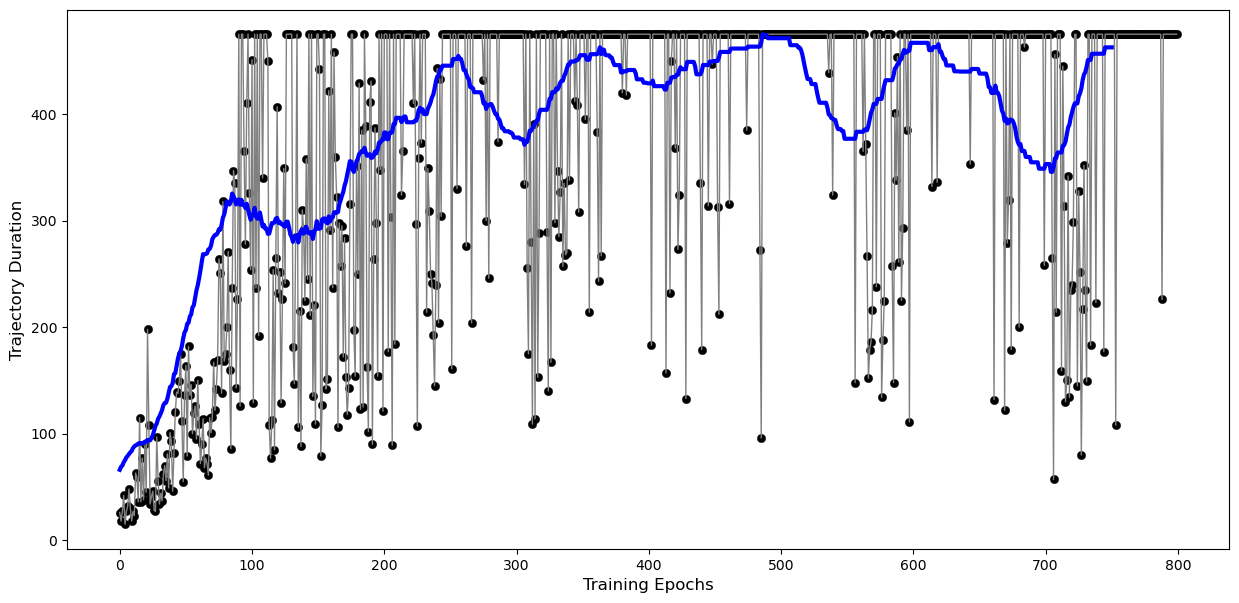

In [10]:
def running_mean(x, N=50):
    return np.convolve(x, np.ones(N)/N, mode='valid')


score = np.array(trainer.scores)
avg_score = running_mean(score)


def plot_score():
    plt.figure(figsize=(15, 7))
    plt.ylabel("Trajectory Duration", fontsize=12)
    plt.xlabel("Training Epochs", fontsize=12)
    plt.plot(score, color='gray', linewidth=1)
    plt.scatter(np.arange(score.shape[0]), score, color='k', linewidth=0.3)
    plt.plot(avg_score, color='blue', linewidth=3)


plot_score()

## Performance of the final policy


KeyboardInterrupt



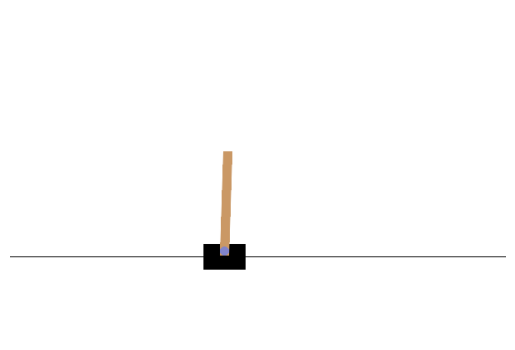

In [11]:
from IPython import display


def watch_agent():
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    state = env.reset()[0]
    rewards = []
    img = plt.imshow(env.render())
    done = False
    while not done:
        pred = model(torch.from_numpy(state).float())
        action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
        next_state, reward, done, _, _ = env.step(action)
        state = next_state

        img.set_data(env.render())
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        rewards.append(reward)

        if done:
            print("Reward:", sum([r for r in rewards]))
            break


watch_agent()